In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import DataLoader
import os
import time
import argparse
import yaml

# Configuration (can be modified directly in the script)
CONFIG = {
    "dataset": {
        "name": "cifar10",
        "data_dir": "./data",
        "batch_size": 128,
        "num_workers": 2  # Reduced for Colab
    },
    "teacher": {
        "model": "resnet50",
        "pretrained": False,
        "epochs": 50,
        "learning_rate": 0.01,
        "momentum": 0.9,
        "weight_decay": 0.0005,
        "scheduler_step_size": 20,
        "scheduler_gamma": 0.1,
        "save_path": "./teacher_model.pth"  # Simplified path for Colab
    }
}

def set_seed(seed=42):
    """Set seed for reproducibility"""
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def get_cifar10_dataloaders(batch_size=128, data_dir='./data', num_workers=2):
    """Get CIFAR-10 dataloaders"""
    # Define normalization (mean & std from CIFAR-10)
    transform_train = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(32, padding=4),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.247, 0.243, 0.261))
    ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.247, 0.243, 0.261))
    ])

    train_dataset = torchvision.datasets.CIFAR10(
        root=data_dir,
        train=True,
        download=True,
        transform=transform_train
    )
    test_dataset = torchvision.datasets.CIFAR10(
        root=data_dir,
        train=False,
        download=True,
        transform=transform_test
    )

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers
    )
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers
    )

    return train_loader, test_loader

def get_teacher_model(model_name="resnet50", num_classes=10, pretrained=False):
    """Create a teacher model based on the model name"""
    if model_name == "resnet50":
        model = models.resnet50(pretrained=pretrained)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    elif model_name == "resnet18":
        model = models.resnet18(pretrained=pretrained)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    else:
        raise ValueError(f"Unsupported model: {model_name}")

    return model

def count_parameters(model):
    """Count the number of trainable parameters in the model"""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def save_model(model, path):
    """Save model to disk"""
    os.makedirs(os.path.dirname(path), exist_ok=True)
    torch.save(model.state_dict(), path)

def train_teacher():
    """Train the teacher model"""
    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Set seed for reproducibility
    set_seed(42)

    # Get dataloaders
    train_loader, test_loader = get_cifar10_dataloaders(
        batch_size=CONFIG["dataset"]["batch_size"],
        data_dir=CONFIG["dataset"]["data_dir"],
        num_workers=CONFIG["dataset"]["num_workers"]
    )

    # Create model
    model = get_teacher_model(
        model_name=CONFIG["teacher"]["model"],
        num_classes=10,
        pretrained=CONFIG["teacher"]["pretrained"]
    )
    model = model.to(device)

    # Print model info
    num_params = count_parameters(model)
    print(f"Teacher model: {CONFIG['teacher']['model']}")
    print(f"Number of parameters: {num_params:,}")

    # Define loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(
        model.parameters(),
        lr=CONFIG["teacher"]["learning_rate"],
        momentum=CONFIG["teacher"]["momentum"],
        weight_decay=CONFIG["teacher"]["weight_decay"]
    )
    scheduler = optim.lr_scheduler.StepLR(
        optimizer,
        step_size=CONFIG["teacher"]["scheduler_step_size"],
        gamma=CONFIG["teacher"]["scheduler_gamma"]
    )

    # Create model directory if needed
    os.makedirs(os.path.dirname(CONFIG["teacher"]["save_path"]), exist_ok=True)

    # Training loop
    best_acc = 0.0
    start_time = time.time()

    for epoch in range(1, CONFIG["teacher"]["epochs"] + 1):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_loss = running_loss / total
        train_acc = correct / total

        # Evaluation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

        val_loss /= val_total
        val_acc = val_correct / val_total

        # Print progress
        print(
            f"Epoch [{epoch}/{CONFIG['teacher']['epochs']}] "
            f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
            f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}"
        )

        # Save best model
        if val_acc > best_acc:
            best_acc = val_acc
            save_model(model, CONFIG["teacher"]["save_path"])
            print(f"Saved best model with val acc: {best_acc:.4f}")

        # Update learning rate
        scheduler.step()

    # Log training time and final metrics
    training_time = time.time() - start_time
    print(f"Training complete. Best val acc: {best_acc:.4f}")
    print(f"Total training time: {training_time:.2f} seconds")

if __name__ == "__main__":
    # Google Colab setup instructions
    print("=" * 80)
    print("INSTRUCTIONS FOR GOOGLE COLAB:")
    print("1. Upload this script to Colab")
    print("2. Run the script with GPU enabled (Runtime > Change runtime type > GPU)")
    print("3. After training, download the teacher_model.pth file")
    print("4. Place the downloaded model in your local project's models directory")
    print("=" * 80)

    # Train the teacher model
    train_teacher()

INSTRUCTIONS FOR GOOGLE COLAB:
1. Upload this script to Colab
2. Run the script with GPU enabled (Runtime > Change runtime type > GPU)
3. After training, download the teacher_model.pth file
4. Place the downloaded model in your local project's models directory
Using device: cuda


100%|██████████| 170M/170M [00:04<00:00, 42.3MB/s]
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Teacher model: resnet50
Number of parameters: 23,528,522
Epoch [1/50] Train Loss: 2.6994 | Train Acc: 0.2455 | Val Loss: 72.1483 | Val Acc: 0.2784
Saved best model with val acc: 0.2784
Epoch [2/50] Train Loss: 2.3727 | Train Acc: 0.2654 | Val Loss: 1.9020 | Val Acc: 0.3013
Saved best model with val acc: 0.3013
Epoch [3/50] Train Loss: 2.0293 | Train Acc: 0.3270 | Val Loss: 2.2354 | Val Acc: 0.3784
Saved best model with val acc: 0.3784
Epoch [4/50] Train Loss: 1.8164 | Train Acc: 0.3787 | Val Loss: 2.5137 | Val Acc: 0.4006
Saved best model with val acc: 0.4006
Epoch [5/50] Train Loss: 1.6924 | Train Acc: 0.4213 | Val Loss: 2.3764 | Val Acc: 0.4314
Saved best model with val acc: 0.4314
Epoch [6/50] Train Loss: 1.6157 | Train Acc: 0.4506 | Val Loss: 4.1529 | Val Acc: 0.4568
Saved best model with val acc: 0.4568
Epoch [7/50] Train Loss: 1.5475 | Train Acc: 0.4721 | Val Loss: 6.0475 | Val Acc: 0.4704
Saved best model with val acc: 0.4704
Epoch [8/50] Train Loss: 1.4802 | Train Acc: 0.4970 |

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import DataLoader
import os
import time
import argparse
import yaml
import math

# Configuration (can be modified directly in the script)
CONFIG = {
    "dataset": {
        "name": "cifar10",
        "data_dir": "./data",
        "batch_size": 128,
        "num_workers": 2  # Reduced for Colab
    },
    "teacher": {
        "model": "resnet50",
        "pretrained": True,  # Changed to True to use pretrained weights
        "epochs": 150,  # Increased from 50 to 150
        "learning_rate": 0.01,
        "momentum": 0.9,
        "weight_decay": 0.0005,
        "scheduler": "cosine",  # Changed from step to cosine
        "warmup_epochs": 5,     # Added warmup
        "label_smoothing": 0.1, # Added label smoothing
        "save_path": "./teacher_model.pth"  # Simplified path for Colab
    }
}

def set_seed(seed=42):
    """Set seed for reproducibility"""
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def get_cifar10_dataloaders(batch_size=128, data_dir='./data', num_workers=2):
    """Get CIFAR-10 dataloaders with enhanced augmentation"""
    # Enhanced data augmentation
    transform_train = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(32, padding=4),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Added color jitter
        transforms.RandomRotation(15),  # Added rotation
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.247, 0.243, 0.261)),
        transforms.RandomErasing(p=0.2)  # Added random erasing
    ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.247, 0.243, 0.261))
    ])

    train_dataset = torchvision.datasets.CIFAR10(
        root=data_dir,
        train=True,
        download=True,
        transform=transform_train
    )
    test_dataset = torchvision.datasets.CIFAR10(
        root=data_dir,
        train=False,
        download=True,
        transform=transform_test
    )

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers
    )
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers
    )

    return train_loader, test_loader

def get_teacher_model(model_name="resnet50", num_classes=10, pretrained=False):
    """Create a teacher model based on the model name"""
    if model_name == "resnet50":
        model = models.resnet50(pretrained=pretrained)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    elif model_name == "resnet18":
        model = models.resnet18(pretrained=pretrained)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    else:
        raise ValueError(f"Unsupported model: {model_name}")

    return model

def count_parameters(model):
    """Count the number of trainable parameters in the model"""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def save_model(model, path):
    """Save model to disk"""
    os.makedirs(os.path.dirname(path), exist_ok=True)
    torch.save(model.state_dict(), path)

class WarmupCosineScheduler:
    """Warmup cosine learning rate scheduler"""
    def __init__(self, optimizer, warmup_epochs, total_epochs, min_lr=1e-6):
        self.optimizer = optimizer
        self.warmup_epochs = warmup_epochs
        self.total_epochs = total_epochs
        self.min_lr = min_lr
        self.base_lrs = [group['lr'] for group in optimizer.param_groups]

    def step(self, epoch):
        if epoch < self.warmup_epochs:
            # Linear warmup
            lr_scale = epoch / self.warmup_epochs
            for i, param_group in enumerate(self.optimizer.param_groups):
                param_group['lr'] = self.base_lrs[i] * lr_scale
        else:
            # Cosine annealing
            progress = (epoch - self.warmup_epochs) / (self.total_epochs - self.warmup_epochs)
            cosine_decay = 0.5 * (1 + math.cos(math.pi * progress))
            for i, param_group in enumerate(self.optimizer.param_groups):
                param_group['lr'] = self.min_lr + (self.base_lrs[i] - self.min_lr) * cosine_decay

def train_teacher():
    """Train the teacher model"""
    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Set seed for reproducibility
    set_seed(42)

    # Get dataloaders
    train_loader, test_loader = get_cifar10_dataloaders(
        batch_size=CONFIG["dataset"]["batch_size"],
        data_dir=CONFIG["dataset"]["data_dir"],
        num_workers=CONFIG["dataset"]["num_workers"]
    )

    # Create model
    model = get_teacher_model(
        model_name=CONFIG["teacher"]["model"],
        num_classes=10,
        pretrained=CONFIG["teacher"]["pretrained"]
    )
    model = model.to(device)

    # Print model info
    num_params = count_parameters(model)
    print(f"Teacher model: {CONFIG['teacher']['model']}")
    print(f"Number of parameters: {num_params:,}")

    # Define loss and optimizer
    criterion = nn.CrossEntropyLoss(label_smoothing=CONFIG["teacher"]["label_smoothing"])
    optimizer = optim.SGD(
        model.parameters(),
        lr=CONFIG["teacher"]["learning_rate"],
        momentum=CONFIG["teacher"]["momentum"],
        weight_decay=CONFIG["teacher"]["weight_decay"]
    )

    # Define scheduler
    if CONFIG["teacher"]["scheduler"] == "cosine":
        scheduler = WarmupCosineScheduler(
            optimizer=optimizer,
            warmup_epochs=CONFIG["teacher"]["warmup_epochs"],
            total_epochs=CONFIG["teacher"]["epochs"]
        )
    else:
        scheduler = optim.lr_scheduler.StepLR(
            optimizer,
            step_size=CONFIG["teacher"]["scheduler_step_size"],
            gamma=CONFIG["teacher"]["scheduler_gamma"]
        )

    # Create model directory if needed
    os.makedirs(os.path.dirname(CONFIG["teacher"]["save_path"]), exist_ok=True)

    # Training loop
    best_acc = 0.0
    start_time = time.time()

    for epoch in range(1, CONFIG["teacher"]["epochs"] + 1):
        # Update learning rate
        if CONFIG["teacher"]["scheduler"] == "cosine":
            scheduler.step(epoch)

        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_loss = running_loss / total
        train_acc = correct / total

        # Evaluation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

        val_loss /= val_total
        val_acc = val_correct / val_total

        # Print progress
        print(
            f"Epoch [{epoch}/{CONFIG['teacher']['epochs']}] "
            f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
            f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | "
            f"LR: {optimizer.param_groups[0]['lr']:.6f}"
        )

        # Save best model
        if val_acc > best_acc:
            best_acc = val_acc
            save_model(model, CONFIG["teacher"]["save_path"])
            print(f"Saved best model with val acc: {best_acc:.4f}")

            # Early stopping if we reach target accuracy
            if best_acc >= 0.95:
                print(f"Reached target accuracy of 95%! Stopping training.")
                break

        # Update learning rate for step scheduler
        if CONFIG["teacher"]["scheduler"] != "cosine":
            scheduler.step()

    # Log training time and final metrics
    training_time = time.time() - start_time
    print(f"Training complete. Best val acc: {best_acc:.4f}")
    print(f"Total training time: {training_time:.2f} seconds")

if __name__ == "__main__":
    # Google Colab setup instructions
    print("=" * 80)
    print("INSTRUCTIONS FOR GOOGLE COLAB:")
    print("1. Upload this script to Colab")
    print("2. Run the script with GPU enabled (Runtime > Change runtime type > GPU)")
    print("3. After training, download the teacher_model.pth file")
    print("4. Place the downloaded model in your local project's models directory")
    print("=" * 80)

    # Train the teacher model
    train_teacher()

INSTRUCTIONS FOR GOOGLE COLAB:
1. Upload this script to Colab
2. Run the script with GPU enabled (Runtime > Change runtime type > GPU)
3. After training, download the teacher_model.pth file
4. Place the downloaded model in your local project's models directory
Using device: cuda


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 180MB/s]


Teacher model: resnet50
Number of parameters: 23,528,522
Epoch [1/150] Train Loss: 1.5653 | Train Acc: 0.5143 | Val Loss: 1.2095 | Val Acc: 0.6955 | LR: 0.002000
Saved best model with val acc: 0.6955
Epoch [2/150] Train Loss: 1.2424 | Train Acc: 0.6683 | Val Loss: 1.0813 | Val Acc: 0.7603 | LR: 0.004000
Saved best model with val acc: 0.7603
Epoch [3/150] Train Loss: 1.1412 | Train Acc: 0.7165 | Val Loss: 0.9510 | Val Acc: 0.8044 | LR: 0.006000
Saved best model with val acc: 0.8044
Epoch [4/150] Train Loss: 1.0878 | Train Acc: 0.7407 | Val Loss: 0.9513 | Val Acc: 0.8060 | LR: 0.008000
Saved best model with val acc: 0.8060
Epoch [5/150] Train Loss: 1.0599 | Train Acc: 0.7544 | Val Loss: 1.0564 | Val Acc: 0.7792 | LR: 0.010000
Epoch [6/150] Train Loss: 1.0205 | Train Acc: 0.7717 | Val Loss: 0.9444 | Val Acc: 0.8093 | LR: 0.009999
Saved best model with val acc: 0.8093
Epoch [7/150] Train Loss: 0.9894 | Train Acc: 0.7811 | Val Loss: 0.9282 | Val Acc: 0.8210 | LR: 0.009995
Saved best model w

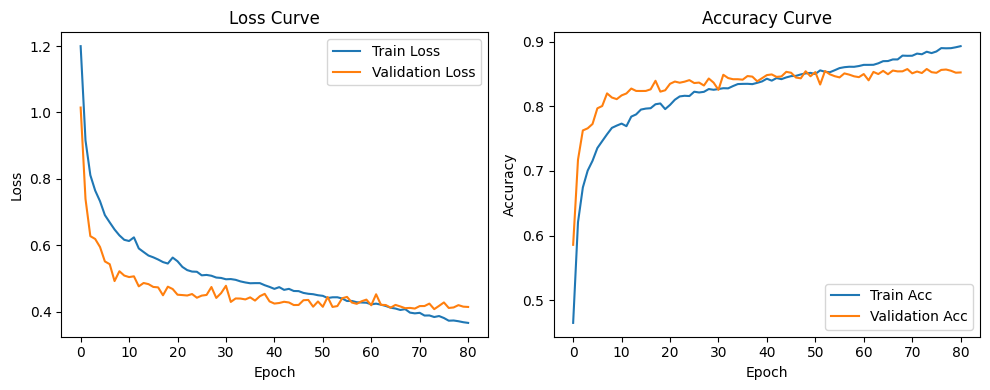

In [ ]:
import re
import matplotlib.pyplot as plt

# Read the training log
with open('/content/teach.txt', 'r') as f:
    lines = f.readlines()

train_loss, val_loss = [], []
train_acc, val_acc = [], []

for line in lines:
    match = re.search(
        r"Train Loss: ([0-9.]+) \| Train Acc: ([0-9.]+) \| Val Loss: ([0-9.]+) \| Val Acc: ([0-9.]+)",
        line
    )
    if match:
        train_loss.append(float(match.group(1)))
        train_acc.append(float(match.group(2)))
        val_loss.append(float(match.group(3)))
        val_acc.append(float(match.group(4)))

# Plotting
plt.figure(figsize=(10, 4))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Train Acc')
plt.plot(val_acc, label='Validation Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()

plt.tight_layout()
plt.show()
